In [1]:
#pip install tf_keras #To avoid keras layers issue during transfer learning

In [2]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt

2024-04-10 03:55:51.066590: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 03:55:51.066691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 03:55:51.212793: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
print(tf.__version__)

2.15.0


In [4]:
!ls -al /kaggle/input/microsoft-catsvsdogs-dataset

total 44
drwxr-xr-x 3 nobody nogroup     0 Jul 30  2021  .
drwxr-xr-x 3 root   root     4096 Apr 10 03:53  ..
-rw-r--r-- 1 nobody nogroup 35545 Jul 30  2021 'MSR-LA - 3467.docx'
drwxr-xr-x 4 nobody nogroup     0 Jul 30  2021  PetImages
-rw-r--r-- 1 nobody nogroup   104 Jul 30  2021 'readme[1].txt'


In [5]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("/kaggle/input/microsoft-catsvsdogs-dataset/PetImages"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages'
There are 0 directories and 12501 images in '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog'
There are 0 directories and 12501 images in '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat'


In [6]:
import pathlib
import numpy as np
data_dir = pathlib.Path("/kaggle/input/microsoft-catsvsdogs-dataset/PetImages") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['Cat' 'Dog']


In [7]:
# View an image
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (380, 316, 3)


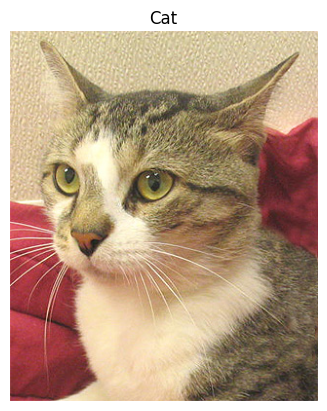

In [19]:
# View a random image from the training dataset
img = view_random_image(target_dir="/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/",target_class="Cat")

Image shape: (465, 500, 3)


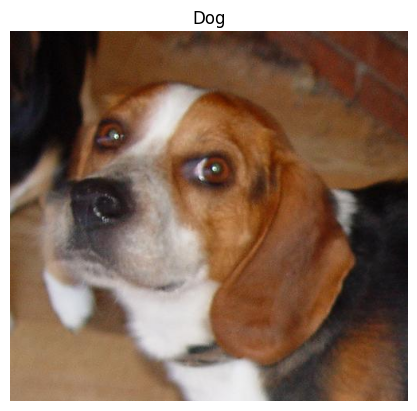

In [20]:
img = view_random_image(target_dir="/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/",target_class="Dog")

In [21]:
import shutil


def copy_images_by_index(source_dir, dest_dir, start_index, end_index):
    # Ensure destination directory exists
    os.makedirs(dest_dir, exist_ok=True)
    
    # Get the list of images sorted by name
    images = sorted(os.listdir(source_dir))
    
    # Ensure start_index and end_index are within the range of available images
    start_index = max(0, min(start_index, len(images)))
    end_index = max(start_index, min(end_index, len(images)))
    
    # Copy images from start_index to end_index
    for index in range(start_index, end_index):
        image_name = images[index]
        source_image_path = os.path.join(source_dir, image_name)
        dest_image_path = os.path.join(dest_dir, image_name)
        shutil.copy(source_image_path, dest_image_path)

        

copy_images_by_index("/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat", "/kaggle/working/train/Cat", 0, 250)
copy_images_by_index("/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog", "/kaggle/working/train/Dog", 0, 250)
copy_images_by_index("/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat", "/kaggle/working/test/Cat", 500, 550)
copy_images_by_index("/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog", "/kaggle/working/test/Dog", 500, 550)

print("Images copied successfully.")

Images copied successfully.


In [22]:
# To remove all directories and images, in case for clean up purposes
# shutil.rmtree("/kaggle/working/test")
# shutil.rmtree("/kaggle/working/train")

In [23]:
# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("/kaggle/working/"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 3 directories and 0 images in '/kaggle/working/'
There are 0 directories and 0 images in '/kaggle/working/.virtual_documents'
There are 2 directories and 0 images in '/kaggle/working/test'
There are 0 directories and 50 images in '/kaggle/working/test/Dog'
There are 0 directories and 50 images in '/kaggle/working/test/Cat'
There are 2 directories and 0 images in '/kaggle/working/train'
There are 0 directories and 250 images in '/kaggle/working/train/Dog'
There are 0 directories and 250 images in '/kaggle/working/train/Cat'


In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the 
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "/kaggle/working/train"
test_dir = "/kaggle/working/test"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42,
                                               shuffle=True)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42,
                                               shuffle=True)

Found 500 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [25]:
# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
])

# Compile the model
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/10


I0000 00:00:1712721475.568303     127 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 [==============================] - 11s 377ms/step - loss: 0.7417 - accuracy: 0.5060 - val_loss: 0.7725 - val_accuracy: 0.4800
Epoch 2/10
16/16 [==============================] - 5s 340ms/step - loss: 0.6862 - accuracy: 0.5400 - val_loss: 0.7052 - val_accuracy: 0.6700
Epoch 3/10
16/16 [==============================] - 6s 347ms/step - loss: 0.6811 - accuracy: 0.5300 - val_loss: 0.7480 - val_accuracy: 0.5100
Epoch 4/10
16/16 [==============================] - 5s 339ms/step - loss: 0.6786 - accuracy: 0.5420 - val_loss: 0.7160 - val_accuracy: 0.5800
Epoch 5/10
16/16 [==============================] - 6s 348ms/step - loss: 0.6696 - accuracy: 0.5840 - val_loss: 0.7251 - val_accuracy: 0.5100
Epoch 6/10
16/16 [==============================] - 6s 361ms/step - loss: 0.6810 - accuracy: 0.5720 - val_loss: 0.6841 - val_accuracy: 0.5600
Epoch 7/10
16/16 [==============================] - 6s 353ms/step - loss: 0.6715 - accuracy: 0.5200 - val_loss: 0.6832 - val_accuracy: 0.5600
Epoch 8/10
16/16

In [26]:
loss,accuracy=model_1.evaluate(valid_data)
print(f"Model loss on the test set: {loss}")
print(f"Model accuracy on the test set: {100*accuracy:.2f}%")

4/4 [==============================] - 0s 52ms/step - loss: 0.8002 - accuracy: 0.5700
Model loss on the test set: 0.8001762628555298
Model accuracy on the test set: 57.00%


<Axes: >

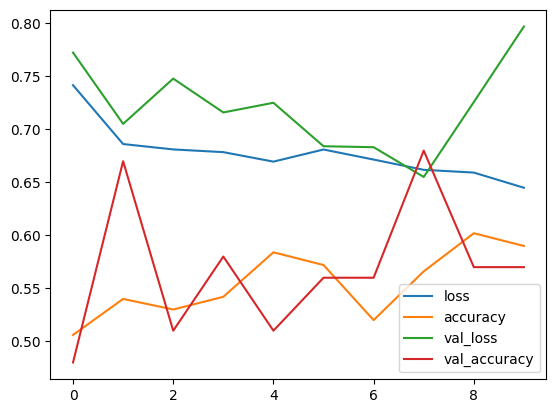

In [27]:
pd.DataFrame(history_1.history).plot()

In [65]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 10)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                   

# Use Transfer learning

In [28]:
os.environ['TF_USE_LEGACY_KERAS'] = '1'
#pip install tf_keras

In [29]:
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras as keras


In [30]:
feature_extractor_layer = hub.KerasLayer("https://www.kaggle.com/models/tensorflow/resnet-50/TensorFlow2/classification/1",
                                        trainable=False, # freeze the underlying patterns
                                        name='feature_extraction_layer',
                                        input_shape=(224,224,3)) # define the input image shape
  
  # Create our own model
model_tl = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    tf.keras.layers.Dense(1, activation='sigmoid') # create our own output layer     
  ])

# Compile
model_tl.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [31]:
history_2 = model_tl.fit(train_data,
                        epochs=25,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/25
16/16 [==============================] - 16s 495ms/step - loss: 0.6880 - accuracy: 0.6500 - val_loss: 0.6856 - val_accuracy: 0.7500
Epoch 2/25
16/16 [==============================] - 6s 354ms/step - loss: 0.6832 - accuracy: 0.8280 - val_loss: 0.6802 - val_accuracy: 0.9100
Epoch 3/25
16/16 [==============================] - 6s 357ms/step - loss: 0.6787 - accuracy: 0.8980 - val_loss: 0.6750 - val_accuracy: 0.9600
Epoch 4/25
16/16 [==============================] - 6s 357ms/step - loss: 0.6745 - accuracy: 0.9200 - val_loss: 0.6699 - val_accuracy: 0.9800
Epoch 5/25
16/16 [==============================] - 6s 369ms/step - loss: 0.6701 - accuracy: 0.9240 - val_loss: 0.6647 - val_accuracy: 1.0000
Epoch 6/25
16/16 [==============================] - 6s 360ms/step - loss: 0.6651 - accuracy: 0.9540 - val_loss: 0.6597 - val_accuracy: 1.0000
Epoch 7/25
16/16 [==============================] - 6s 370ms/step - loss: 0.6603 - accuracy: 0.9700 - val_loss: 0.6547 - val_accuracy: 1.0000
Epoch

In [32]:
loss,accuracy=model_tl.evaluate(valid_data)
print(f"Model loss on the test set: {loss}")
print(f"Model accuracy on the test set: {100*accuracy:.2f}%")

4/4 [==============================] - 0s 56ms/step - loss: 0.5716 - accuracy: 1.0000
Model loss on the test set: 0.5716468691825867
Model accuracy on the test set: 100.00%


<Axes: >

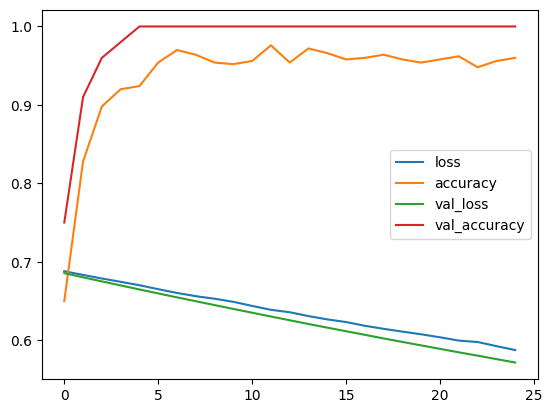

In [33]:
pd.DataFrame(history_2.history).plot()

In [64]:
model_tl.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1001)              25612201  
 KerasLayer)                                                     
                                                                 
 dense_1 (Dense)             (None, 1)                 1002      
                                                                 
Total params: 25613203 (97.71 MB)
Trainable params: 1002 (3.91 KB)
Non-trainable params: 25612201 (97.70 MB)
_________________________________________________________________


# Download sample image from internet and predict

--2024-04-10 04:19:18--  https://cdn.pixabay.com/photo/2020/03/31/19/20/dog-4988985_640.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.40.96, 172.64.147.160, 2606:4700:4400::6812:2860, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.40.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50478 (49K) [binary/octet-stream]
Saving to: 'dog_sample.jpg'

dog_sample.jpg      100%[===================>]  49.29K  --.-KB/s    in 0.008s  

2024-04-10 04:19:19 (6.05 MB/s) - 'dog_sample.jpg' saved [50478/50478]



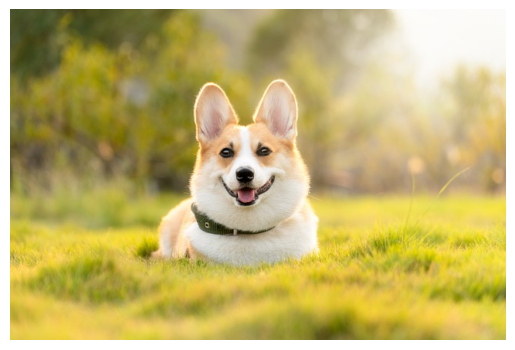

In [51]:
# View our example image
!wget -O dog_sample.jpg https://cdn.pixabay.com/photo/2020/03/31/19/20/dog-4988985_640.jpg
steak = mpimg.imread("dog_sample.jpg")
plt.imshow(steak)
plt.axis(False);

In [60]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [92]:
# Load in and preprocess our custom image
dog_cartoon = load_and_prep_image("dog_sample.jpg")

In [89]:
# The batch size becomes the first dimension. So in reality, our model was trained on data in the shape of (batch_size, 224, 224, 3).
print(f"Shape before new dimension: {dog_cartoon.shape}")
dog_cartoon = tf.expand_dims(dog_cartoon, axis=0) # add an extra dimension at axis 0
print(f"Shape after new dimension: {dog_cartoon.shape}")

Shape before new dimension: (224, 224, 3)
Shape after new dimension: (1, 224, 224, 3)


In [113]:
def make_predictions(model,image,class_names):
    image_convert_dim = tf.expand_dims(image, axis=0) # add an extra dimension at axis 0
    prediction = model.predict(image_convert_dim)
    pred_class = class_names[int(tf.round(prediction)[0][0])]
    print(f"The image belong to {pred_class} category")

In [114]:
make_predictions(model_tl,dog_cartoon,class_names)

1/1 [==============================] - 0s 22ms/step
The image belong to Dog category


--2024-04-10 04:39:05--  https://upload.wikimedia.org/wikipedia/commons/a/a5/Red_Kitten_01.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3136473 (3.0M) [image/jpeg]
Saving to: 'cat_sample.jpg'

cat_sample.jpg      100%[===================>]   2.99M  16.4MB/s    in 0.2s    

2024-04-10 04:39:06 (16.4 MB/s) - 'cat_sample.jpg' saved [3136473/3136473]



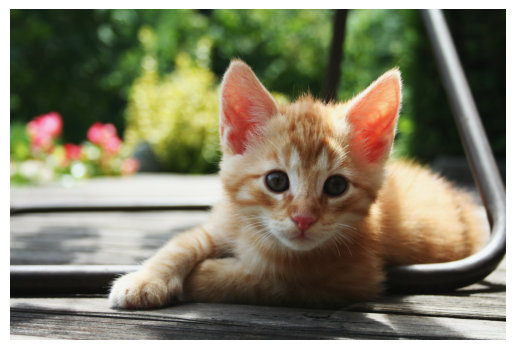

In [110]:

# View our example image
!wget -O cat_sample.jpg https://upload.wikimedia.org/wikipedia/commons/a/a5/Red_Kitten_01.jpg
steak = mpimg.imread("cat_sample.jpg")
plt.imshow(steak)
plt.axis(False);

In [115]:
cat_cartoon = load_and_prep_image("cat_sample.jpg")
make_predictions(model_tl,cat_cartoon,class_names)

1/1 [==============================] - 0s 22ms/step
The image belong to Cat category
